## Make patches from labels

Make a set of augmented patches from labels.

The difference between labels and patches is:

1.  Labels are a set of images and annotated ground truths, generated manually, or automatically.  Labels can be different sizes.
2.  Patches are a set of images and annotated ground truths generated from labels.  They are usually cropped from labels to be all the same size.  They are often augmented.  1 label can be used to generate many patches. 

In [2]:
from skimage.io import imread
from matplotlib import pyplot as plt
from tnia.deeplearning.dl_helper import quantile_normalization, get_label_paths
from tnia.plotting.plt_helper import imshow_multi2d
import numpy as np
import json
from glob import glob
import pandas as pd
import os
from pathlib import Path
from tnia.deeplearning.augmentation import uber_augmenter

data_path = r'../../data'
parent_path = os.path.join(data_path, 'ladybugs_sparse')
label_path = os.path.join(parent_path, 'labels')

# open the info file
json_name = os.path.join(label_path, 'info.json')
json_ = json.load(open(json_name))

# get number of inputs and number of ground truths for this problem
num_inputs = json_['num_inputs']
num_ground_truths = json_['num_truths']
print('num inputs: ', num_inputs)   
print('num ground truth: ', num_ground_truths)

image_label_paths, ground_truths_label_paths = get_label_paths(1, num_ground_truths, label_path)
print('image label paths',image_label_paths)
print("ground_truth_label_paths", ground_truths_label_paths[0])

# get list of tif files in image_label_path
tif_files = glob(str(os.path.join(image_label_paths[0], '*.tif')))
json_files = glob(str(os.path.join(image_label_paths[0], '*.json')))
print()
for tif_file in tif_files:
    print("tif_file: ", tif_file)

patch_path= os.path.join(parent_path, 'patches')

if not os.path.exists(patch_path):
    os.mkdir(patch_path)
axes = 'YXC'
sub_sample = 1



num inputs:  1
num ground truth:  1
image label paths [PosixPath('/home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/labels/input0')]
ground_truth_label_paths /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/labels/ground truth0

tif_file:  /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/labels/input0/6410573_8085113_0.tif
tif_file:  /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/labels/input0/8220954_10897041_0.tif


## Optionally delete old patches

If you previously generated patches, optionally manually delete them (otherwise the new patches will be added to the old set, which could be OK in some cases, but if you add labels and re-augment many times you may end up with a lot (thousands and thousands) of patches)

##  Augment 

In this step we loop through all the labels, normalize them and augment each label to create patches. 

Normalization is always tricky.  We want to normalize based on the expected range in real images, which are often larger than training patches.  

Augmentation takes one label, crops it to the right size to use as input for the neural network, then applies transformations like stretch, mirror, rotate and brightness and color transformations.  This is done to increase the size of the training data.  Transformations are applied to one label to create many training patches. 


tiff name is 6410573_8085113_0.tif


/home/bnorthan/code/i2k/tnia/tnia-python/tnia/deeplearning/augmentation.py:227: UserWarning: /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/patches/ground truth0/grid_31.tif is a low contrast image
  imsave(label_name, label_aug[j])
/home/bnorthan/code/i2k/tnia/tnia-python/tnia/deeplearning/augmentation.py:227: UserWarning: /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/patches/ground truth0/grid_353.tif is a low contrast image
  imsave(label_name, label_aug[j])
/home/bnorthan/mambaforge/envs/easy_augment_pytorch/lib/python3.12/site-packages/albumentations/augmentations/functional.py:747: RuntimeWarning: invalid value encountered in power
  return np.power(img, gamma)
/home/bnorthan/code/i2k/tnia/tnia-python/tnia/deeplearning/augmentation.py:227: UserWarning: /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/patches/ground truth0/grid_459.tif is a low contrast image
  imsav

tiff name is 8220954_10897041_0.tif


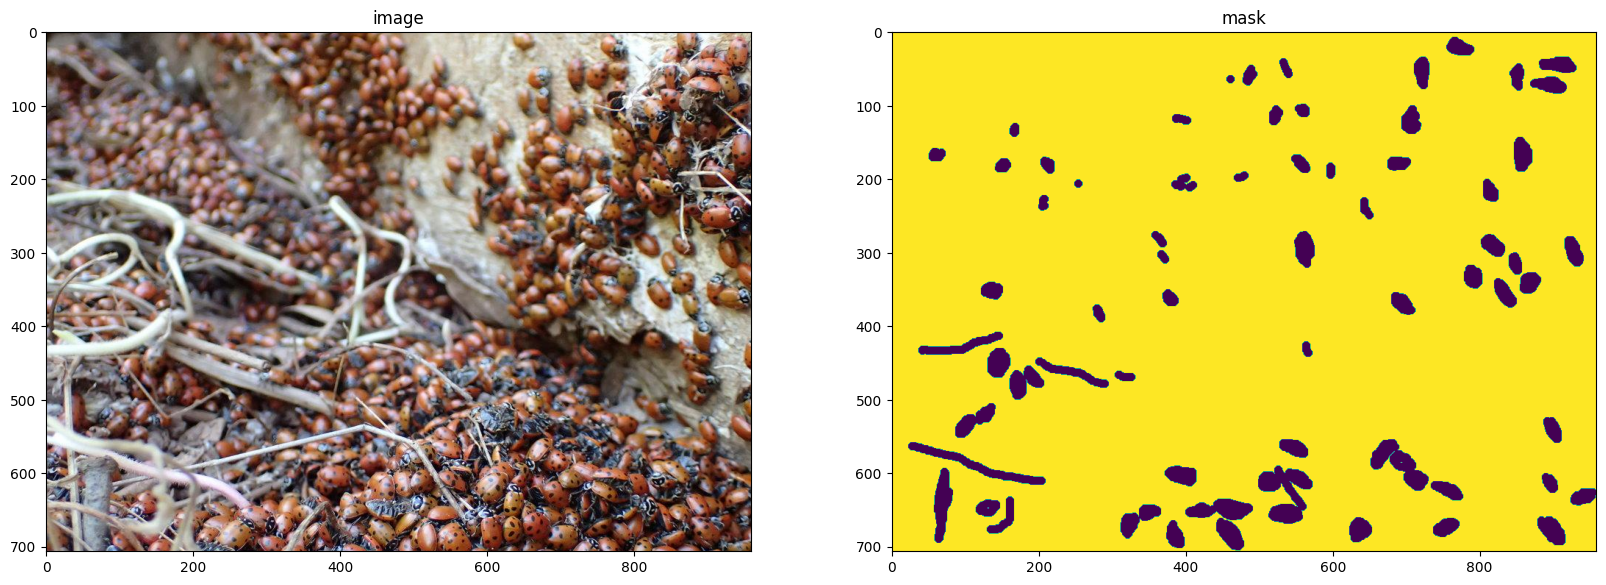

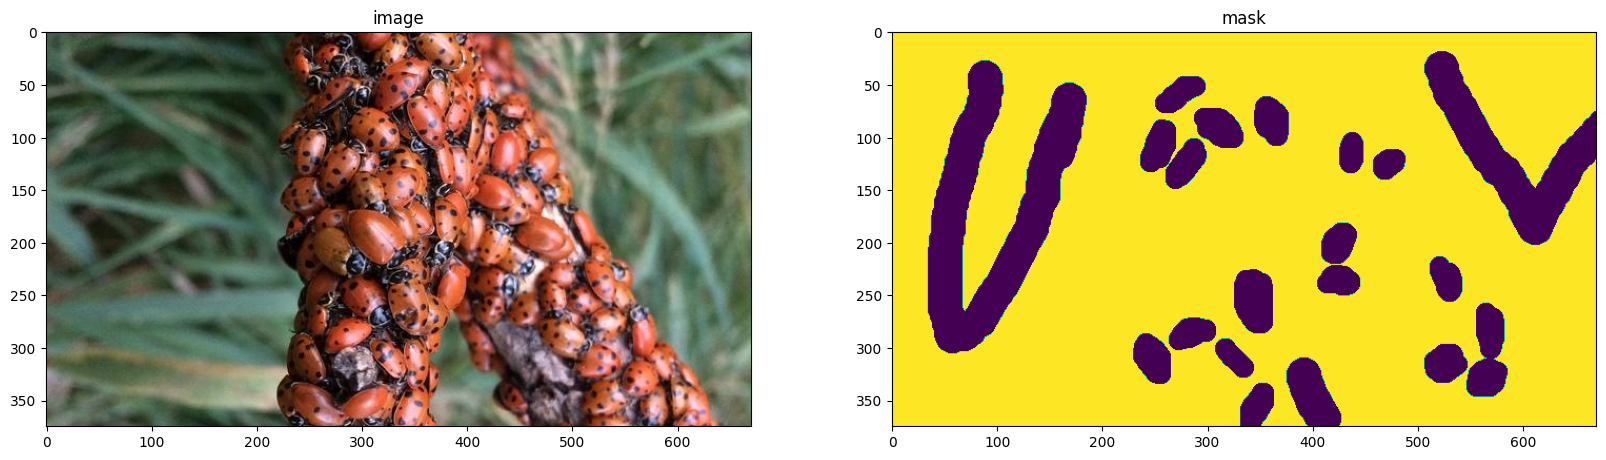

In [3]:
patch_size = 256
number_patches = 200

# create a df to save the label names in 
df = pd.DataFrame(columns=['base_name', 'xstart', 'ystart', 'xend', 'yend'])  

for i in range(len(tif_files)):
    # User input set index of label

    # get tif name
    tif_name = os.path.basename(tif_files[i])
    print('tiff name is', tif_name)

    image = imread(str(image_label_paths[0]/ (tif_name)))

    image = image

    # read labels (there can be more than one class)
    labels = []
    for ground_truths_label_path in ground_truths_label_paths:
        label = imread(os.path.join(ground_truths_label_path / (tif_name)))
        label = label-1
        labels.append(label)

    # show labels image 
    images_to_show=[]
    titles = []
    images_to_show.append(image)
    titles.append("image")

    for label in labels:
        images_to_show.append(label)
        titles.append("mask")

    fig = imshow_multi2d(images_to_show, titles, 1, len(images_to_show), width=20, height=10)
    
    image = quantile_normalization(image, quantile_low = .01, quantile_high=.998, clip = False).astype(np.float32)
    
    uber_augmenter(image, labels, Path(patch_path), 'grid', patch_size, number_patches, do_random_brightness_contrast = False, do_random_gamma=False)
    uber_augmenter(image, labels, Path(patch_path), 'grid', patch_size, number_patches, do_random_brightness_contrast = True, do_random_gamma=False)
    uber_augmenter(image, labels, Path(patch_path), 'grid', patch_size, number_patches, do_random_brightness_contrast = True, do_random_gamma=True)
    uber_augmenter(image, labels, Path(patch_path), 'grid', patch_size, number_patches, do_random_brightness_contrast = True, do_random_gamma=True, do_color_jitter = True)
